# Unified WOfS Product

This algorithm brings together four water detection products used in the UKSA SPIN project at Satellite Applications Catapult, namely the NDWI and WOfS functionality from Spectral_Products, the WOfS time series detection functionality from Water_WOfS and the radar based WOfS functionalities from Inland_Water_and_Coastal_Monitoring. 
The original authors of basis for the first two products were with Geoscience Australia, while the basis of Inland_Water_and_Coastal_Monitoring was Wil Selwood at SAC, these were then developed into the subsequent products by Jonathan Hicks and Michael Young while at SAC.

Geoscience Australia developed the Australian Water Observations from Space (WOFS) algorithm, providing an estimate of how often water was seen at a particular location. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification.

### Water Inter-Operability - Future Work

Each individual output within this application has its xarray displayed so the similarities and contrasts are clear for any additional efforts in merging the sensors is made easier. 

## 1. Preliminary Steps

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import sys
sys.path.append('/home/jovyan/odc-hub/')

In [11]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import collections
import fiona
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

import csv
from shapely.geometry import MultiLineString, mapping
from skimage.measure import find_contours
from datacube.storage import masking
from matplotlib import cm
from sac_utils.interactive_maps import display_map
from collections import defaultdict


In [13]:
%matplotlib inline
import datacube
import xarray as xr
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
import imp
from time import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

In [31]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


## 2. Define Temporal and Spatial Extent

### Available extents

We've listed the available ingested data that you can explore in the ODC Sandbox. The latitude, longitude and time ranges correspond to the boundaries of the ingested data cubes. You'll be able to explore sub-samples of these cubes. You'll also need to provide the platform, product and resolution information for the cube you're subsampling.

Select an analysis region (Lat-Lon) on create a new one with reference to current coordinates using the map below.  
- HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
- Available time for current S1 data = 2018-04-02 to 2019-03-28, for S2 = 2018-08-25 to 2019-03-21 and Landsat 8 = 2013-01-01 to 2019-03-28

Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
This region and time period will be used for the cloud assessment

In [32]:
# time = ('2019-02-01', '2019-04-01')
time = ('2019-02-01', '2019-04-01')
# time = ('2014-01-01', '2016-01-01')

# River Example - Sigatoka River
# longitude = (177.74, 177.92)
# latitude = (-17.95, -17.82)
# xmin = 578362.16
# xmax = 597495.37
# ymin = 8015190.29
# ymax = 8029489.22

# Reservoir Example - Vaturu Dam
# longitude = (177.6394, 177.6837)
# latitude = (-17.7574, -17.7074)
# xmin = 567781.67
# xmax = 572498.12
# ymin = 8036539.09
# ymax = 8042054.53

# Lake Example - Central Region Lake
# longitude = (177.96, 178.15)
# latitude = (-17.8, -17.65)
# xmin = 601745.96
# xmax = 621986.65
# ymin = 8031680.87
# ymax = 8048165.18

# Coastline Example - South Coast
# longitude = (177.481, 177.855)
# latitude = (-18.00, -18.3732)
# xmin = 550920.41
# xmax = 590322.94
# ymin = 8009748.41
# ymax = 7968311.82

# Coastline Example 2 - South West Coast
# longitude = (177.39, 177.54)
# latitude = (-18.11, -18.19)
# xmin = 541261.01
# xmax = 557104.97
# ymin = 7988709.38
# ymax = 7997600.76

# South East Coast
longitude = (178.3815, 178.7522)
latitude = (-18.1938, -17.9991)
xmin = 646100.09
xmax = 685516.98
ymin = 7987822.93
ymax = 8009037.29

# Viti Levu, the whole island
# longitude = (177.1594, 178.7222)
# latitude = (-18.2962, -17.2867)
# xmin = 516846.12
# xmax = 683058.38
# ymin = 7977036.18
# ymax = 8087910.63

x = (xmin, xmax)
y = (ymin, ymax)

time_constant = time
longitude_constant = longitude
latitude_constant = latitude
x_constant = x
y_constant = y

ar=abs(longitude[1]-longitude[0])/(latitude[1]-latitude[0])

In [33]:
display_map(latitude,longitude)

# Optical Data

## 3a. Load Optical Datasets 
### ...and the required spectral bands or other parameters
The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands.

In [34]:
# platform= 'SENTINEL_2'
# product='s2_esa_sr_granule'

platform='LANDSAT_8'
product='ls8_usgs_sr_scene'

output_crs = 'EPSG:4326'
resolution = (-0.0001, 0.0001)

In [35]:
%env AWS_NO_SIGN_REQUEST=YES

if product == 's2_esa_sr_granule':
    dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'red',
        'green',
        'blue',
        'nir',
        'swir_1',
        'swir_2',
        'scene_classification'
    )
) 
    dataset['swir1']=dataset.swir_1
    dataset['swir2']=dataset.swir_2
    dataset
    
    
elif product=='ls8_usgs_sr_scene':
    dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'red',
        'green',
        'blue',
        'nir',
        'swir1',
        'swir2',
        'pixel_qa'
    )
) 

env: AWS_NO_SIGN_REQUEST=YES


In [36]:
print(dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708, time: 8)
Coordinates:
  * time       (time) datetime64[ns] 2019-02-05T22:12:34.238081 ... 2019-03-18T22:06:36.782391
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 22 22 14
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 76 76 63
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 ... 181 167
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 32 32 27
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 76 76 74
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 69 69 67
    pixel_qa   (time, latitude, longitude) uint16 1 1 1 1 1 ... 324 324 324 324
Attributes:
    crs:      EPSG:4326


## 4a. Process Optical Cloud Data

### Clean Dataset 

In [37]:
clean_list=np.array([])
for i in range(len(dataset.time)):
    if len(np.unique(dataset.red.isel(time=i).values))==1:
        clean_list=np.append(clean_list, 0)
    else:
        clean_list=np.append(clean_list, 1)

clean_index=list(np.where(clean_list==1)[0])
dataset=dataset.isel(time=clean_index)

### Masking out clouds

As part of the utilities for the Open Data Cube, we have defined a function to mask clouds based on the quality assurance information for Landsat. The function returns an `xarray.DataArray` object containing the mask. This can then be passed to the `where()` function, which masks the data.

In [47]:
from clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(dataset, platform=platform)

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
cleaned_dataset = dataset.where(cloud_mask)
print(cleaned_dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708, time: 6)
Coordinates:
  * time       (time) datetime64[ns] 2019-02-14T22:06:22.187153 ... 2019-03-18T22:06:36.782391
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    red        (time, latitude, longitude) float64 nan nan nan ... 22.0 14.0
    green      (time, latitude, longitude) float64 nan nan nan ... 76.0 63.0
    blue       (time, latitude, longitude) float64 nan nan nan ... 181.0 167.0
    nir        (time, latitude, longitude) float64 nan nan nan ... 32.0 27.0
    swir1      (time, latitude, longitude) float64 nan nan nan ... 76.0 74.0
    swir2      (time, latitude, longitude) float64 nan nan nan ... 69.0 67.0
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 324.0 324.0
Attributes:
    crs:      EPSG:4326


### Remove fill tiles 
Removes the abundance of blank fill tiles which are often imported from the cube when loading LS8 data. 

In [48]:
fcleaned_dataset=cleaned_dataset.fillna(0)
clean_list=np.array([])
for i in range(len(fcleaned_dataset.time)):
    if int(np.sum(fcleaned_dataset.red.isel(time=i).values))==0:
        clean_list=np.append(clean_list, 0)
    else:
        clean_list=np.append(clean_list, 1)


clean_index=list(np.where(clean_list==1)[0])
cleaned_dataset=cleaned_dataset.isel(time=clean_index)
print(cleaned_dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708, time: 6)
Coordinates:
  * time       (time) datetime64[ns] 2019-02-14T22:06:22.187153 ... 2019-03-18T22:06:36.782391
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    red        (time, latitude, longitude) float64 nan nan nan ... 22.0 14.0
    green      (time, latitude, longitude) float64 nan nan nan ... 76.0 63.0
    blue       (time, latitude, longitude) float64 nan nan nan ... 181.0 167.0
    nir        (time, latitude, longitude) float64 nan nan nan ... 32.0 27.0
    swir1      (time, latitude, longitude) float64 nan nan nan ... 76.0 74.0
    swir2      (time, latitude, longitude) float64 nan nan nan ... 69.0 67.0
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 324.0 324.0
Attributes:
    crs:      EPSG:4326


### Create mosaic for false colour composites

In [54]:
from dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic, create_hdmedians_multiple_band_mosaic

# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median, Geomedian, or Max_NDVI 
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

#This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

# # This is the GEOMEDIAN mosaic
# land_and_water_composite = create_hdmedians_multiple_band_mosaic(cleaned_dataset, cloud_mask)

# This is the MAX_NDVI mosaic
# land_and_water_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask)

print(land_and_water_composite)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708)
Coordinates:
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    red        (latitude, longitude) float64 nan nan nan nan ... 48.5 48.5 40.5
    green      (latitude, longitude) float64 nan nan nan ... 103.5 103.5 90.5
    blue       (latitude, longitude) float64 nan nan nan ... 221.5 221.5 207.0
    nir        (latitude, longitude) float64 nan nan nan nan ... 51.0 51.0 47.0
    swir1      (latitude, longitude) float64 nan nan nan nan ... 81.0 81.0 79.0
    swir2      (latitude, longitude) float64 nan nan nan nan ... 70.0 70.0 67.5
    pixel_qa   (latitude, longitude) float64 nan nan nan ... 324.0 324.0 324.0


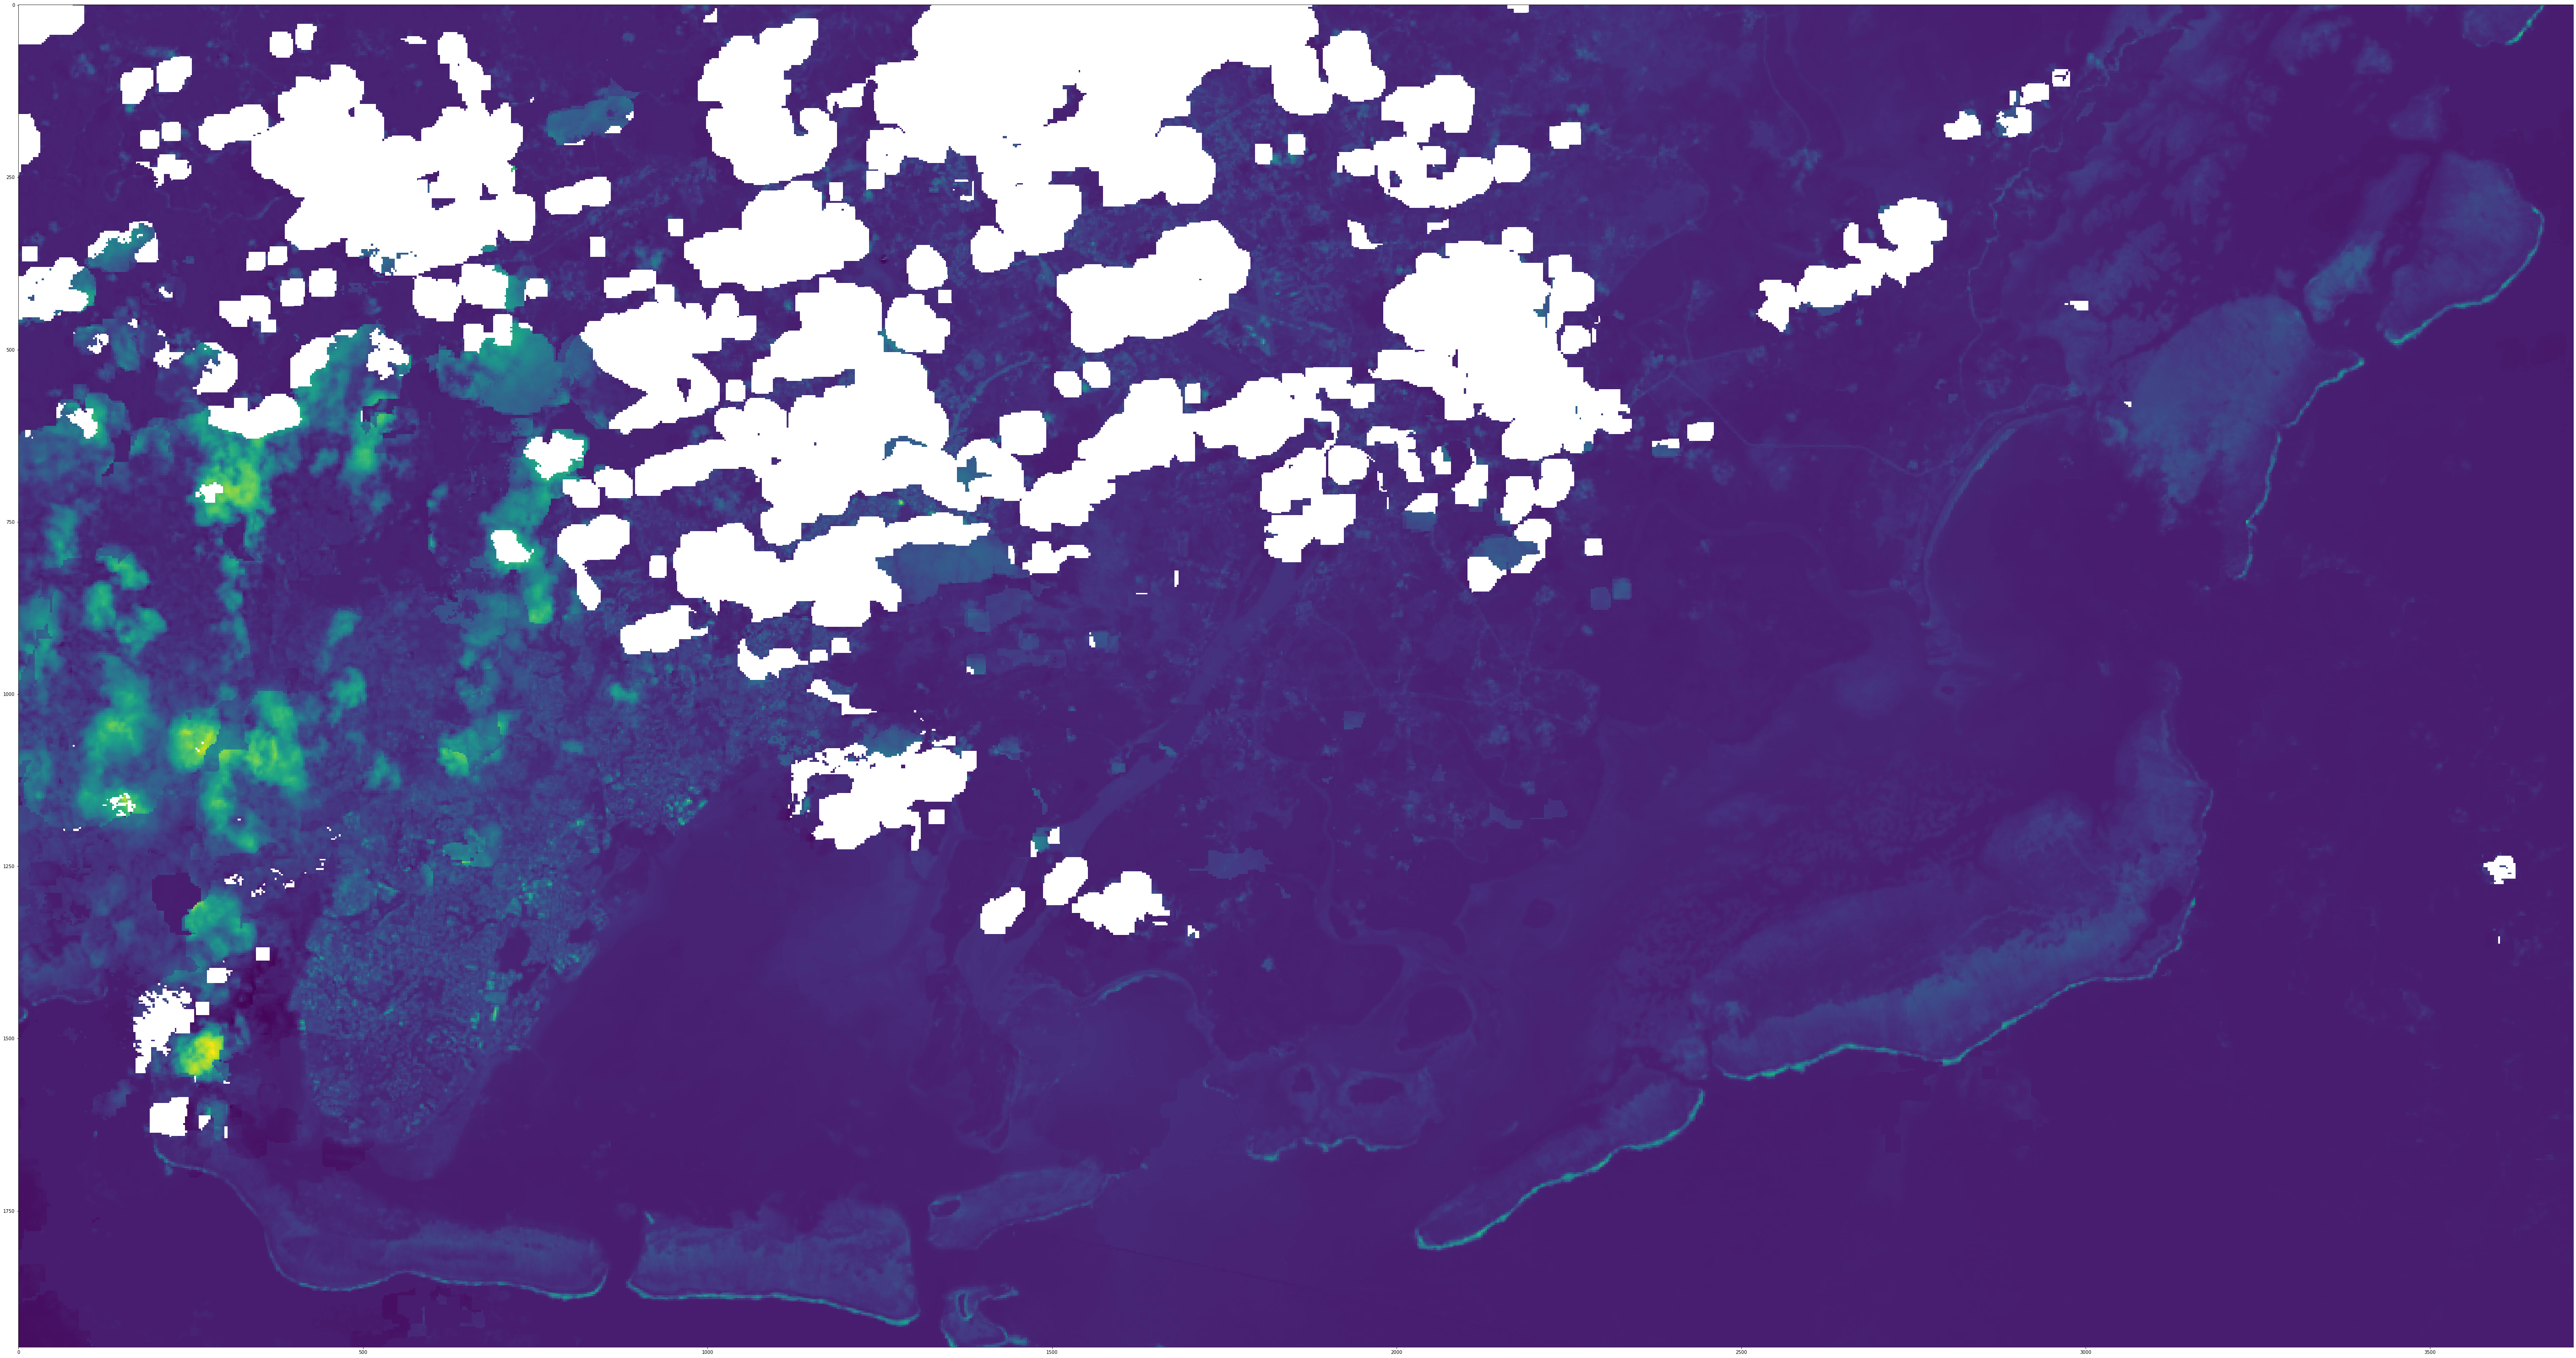

In [64]:
fig, ax = plt.subplots(figsize=(100, 100))
ax.imshow(land_and_water_composite.red);

## 5a. Optical Products 
### 5ai. Spectral Products

#### WOfS

In [66]:
from dc_water_classifier import wofs_classify

In [67]:
if platform == 'LANDSAT_8':
    water_classification = wofs_classify(land_and_water_composite, clean_mask = np.ones(land_and_water_composite.pixel_qa.shape).astype(np.bool),  mosaic = True) 
elif platform == 'SENTINEL_2':
    water_classification = wofs_classify(land_and_water_composite, clean_mask = np.ones(land_and_water_composite.scene_classification.shape).astype(np.bool),  mosaic = True) 

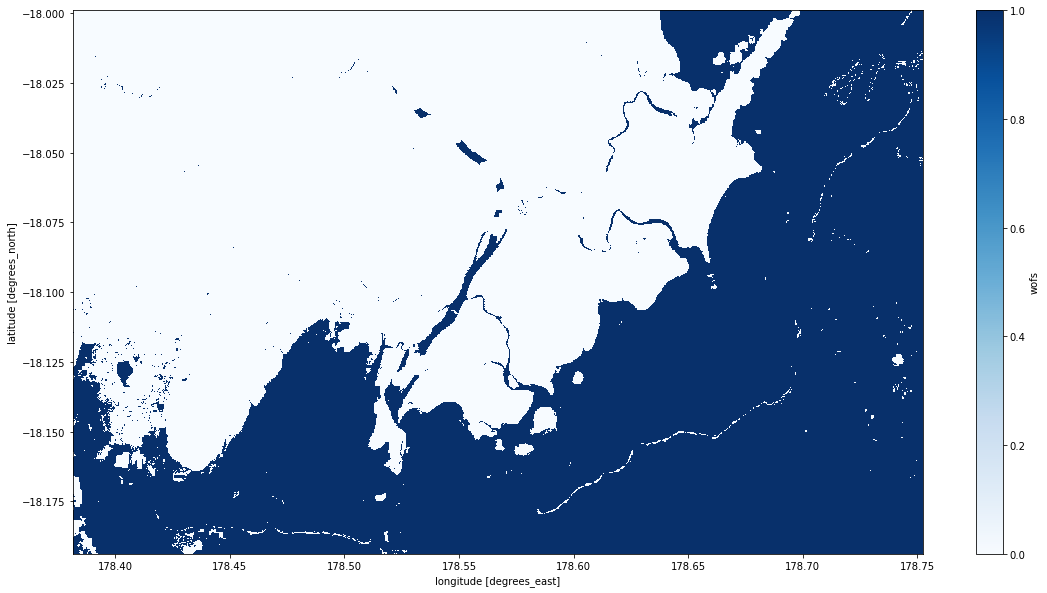

In [68]:
# Plot of WOFS product
# BLUE = 1.0 = Water
# WHITE = 0.0 = Non-Water

water_classification.wofs.plot(cmap='Blues', figsize=(10*ar, 10))
plt.savefig(f"WOFS_product.jpg")

In [69]:
print(water_classification)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708)
Coordinates:
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    wofs       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0


#### NDWI

In [70]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [71]:
ndwi2 = NDWI(land_and_water_composite) # Normalized Difference Water Index

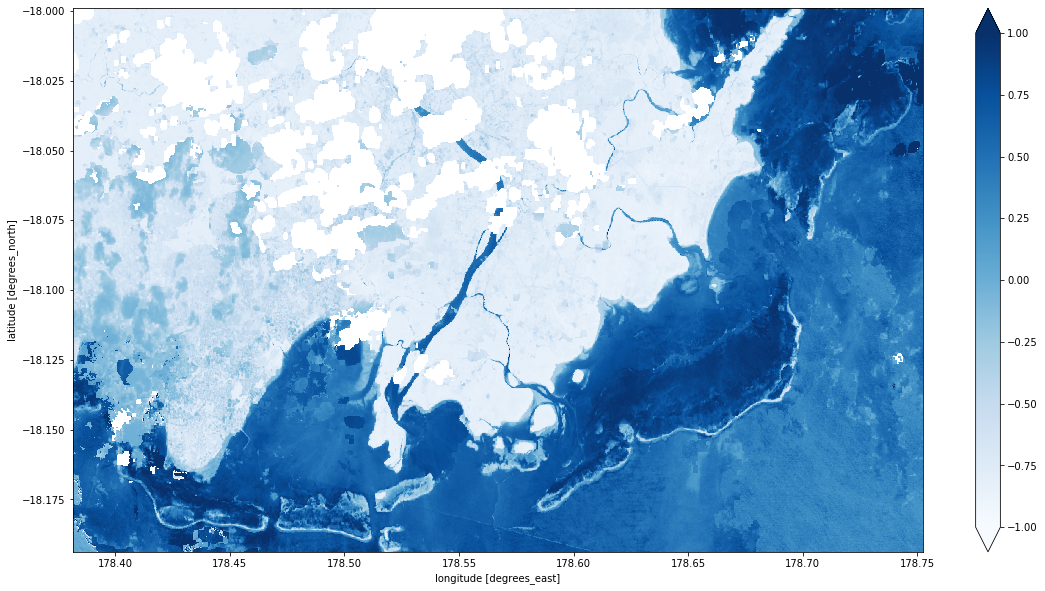

In [72]:
(ndwi2).plot(figsize=(10*ar, 10), cmap = "Blues", vmin=-1.0, vmax=1.0)

In [21]:
print(ndwi2)

<xarray.DataArray (latitude: 1948, longitude: 3708)>
array([[     nan,      nan,      nan, ..., 0.535865, 0.535865, 0.535865],
       [     nan,      nan,      nan, ..., 0.575758, 0.575758, 0.575758],
       [     nan,      nan,      nan, ..., 0.575758, 0.575758, 0.575758],
       ...,
       [0.056452, 0.056452, 0.056452, ..., 0.355805, 0.355805, 0.365079],
       [0.048748, 0.056452, 0.056452, ..., 0.355805, 0.355805, 0.365079],
       [0.048748, 0.056452, 0.056452, ..., 0.339806, 0.339806, 0.316364]])
Coordinates:
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8


#### Threshold count and percentage

In [22]:
from matplotlib.ticker import FuncFormatter

def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))

In [23]:
# NDWI value for water = 0.0 to 1.0

ndwi_minimum_threshold = 0.0
ndwi_maximum_threshold = 1.0

In [24]:
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

threshold_count(ndwi2,ndwi_minimum_threshold,ndwi_maximum_threshold)
threshold_percentage(ndwi2,ndwi_minimum_threshold,ndwi_maximum_threshold)

{'percent_inside_threshold': 45.8278925194208,
 'percent_outside_threshold': 42.15955179876354,
 'percent_clouds': 12.012555681815655}

In [25]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.9 to 1.1 to identify water (1.0)

wofs_minimum_threshold = 0.9
wofs_maximum_threshold = 1.1

In [26]:
threshold_count(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)
threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'percent_inside_threshold': 48.143934863074236,
 'percent_outside_threshold': 51.856065136925764,
 'percent_clouds': 0.0}

### 5aii. WOfS Products

#### Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

The first step is to classify the dataset, which can be done with the `wofs_classify()` utility function.

In [81]:
from dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(cleaned_dataset)

The next step is to convert "no data" pixels to `nan`. A "no data" pixel has a value of `-9999` in Landsat data.

In [82]:
if product=='ls8_usgs_sr_scene':
    ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)
elif product =='s2_esa_sr_granule':
    ts_water_classification = ts_water_classification.where(ts_water_classification != 0).astype(np.float16)

Finally, the percentage of time that a pixel is classified as water is calculated by taking the average classification value over time and multiplying it by 100. The mean calculation ignores `nan` values.

In [83]:
water_classification_percentages = (ts_water_classification.mean(dim=['time']) * 100).wofs.rename('water_classification_percentages')

#### Exploring the results

After calculating the water classification percentage, we can plot it both as a 2-dimensional image and 1-dimensional summary.

The first step is to choose a colour map and change the colour of `nan` pixels to black. We choose to use the `RdBu` colour map to highlight water in blue and land in red.

In [84]:
# import color-scheme and set nans to black
from matplotlib.cm import RdBu
RdBu.set_bad('black', 1)

In the following figure, dark blue indicates pixels that experienced significant or constant water over the time series, where dark red indicates pixels that have experienced little or no water over the time series.

You can adjust the figure size to avoid distortion. Use the `latitude` and `longitude` dimensions from the `xarray` description to get an idea for the desired aspect ratio. You'll need to add some space in the x-dimension to account for the presence of the colour bar. 

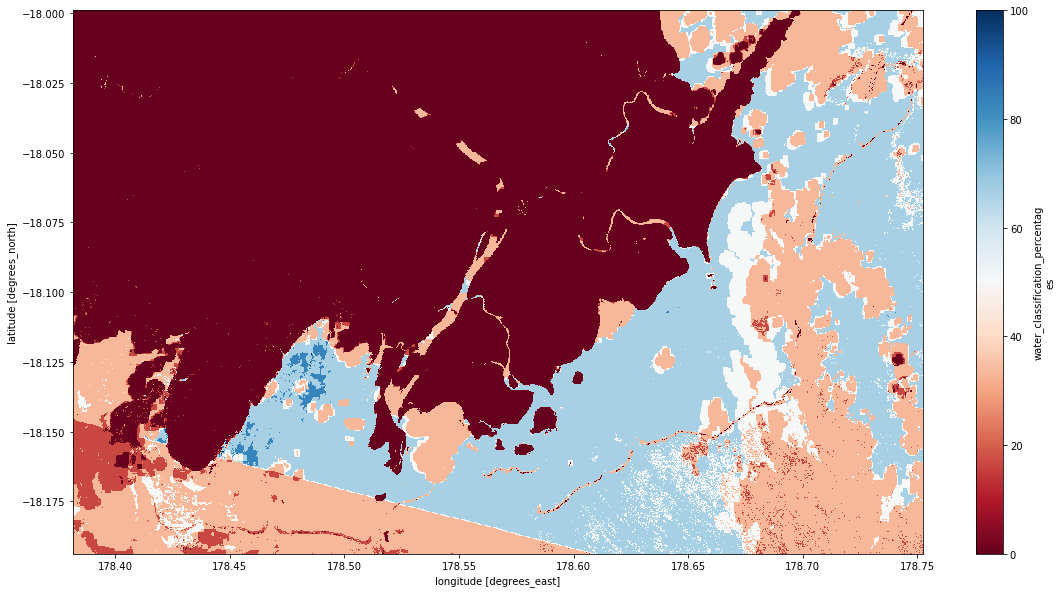

In [85]:
water_classification_percentages.plot(cmap=RdBu, figsize=(10*ar, 10))
plt.show()

In [86]:
print(water_classification_percentages)

<xarray.DataArray 'water_classification_percentages' (latitude: 1948, longitude: 3708)>
array([[ 0.  ,  0.  ,  0.  , ..., 50.  , 50.  , 50.  ],
       [ 0.  ,  0.  ,  0.  , ..., 50.  , 50.  , 50.  ],
       [ 0.  ,  0.  ,  0.  , ..., 50.  , 50.  , 50.  ],
       ...,
       [33.3 , 33.3 , 33.3 , ..., 33.3 , 33.3 , 33.3 ],
       [16.66, 33.3 , 33.3 , ..., 33.3 , 33.3 , 33.3 ],
       [16.66, 33.3 , 33.3 , ..., 33.3 , 33.3 , 33.3 ]], dtype=float16)
Coordinates:
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8


By taking the average classification value over the latitude and longitude, we can assess whether the fraction of water pixels has changed significantly over time. It should be noted that clouds can impact the statistical results. The water classification percentage can be displayed on either a linear scale or a logarithmic scale.

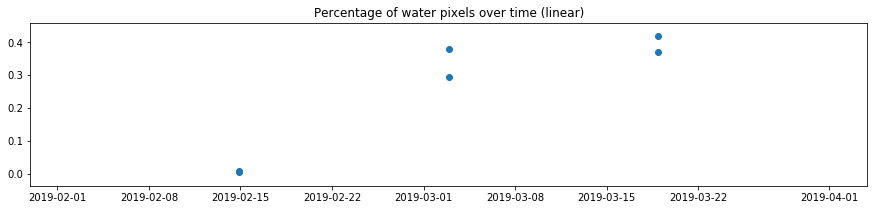

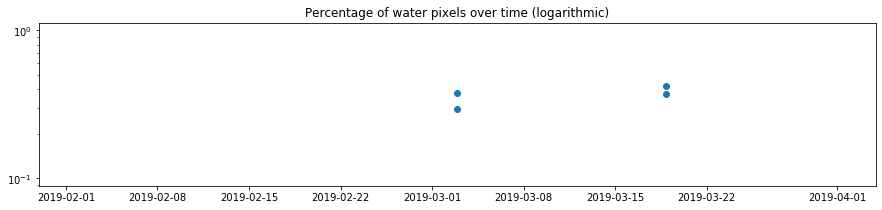

In [87]:
water_classification_mean_percentages = (ts_water_classification.mean(dim=['latitude', 'longitude']) * 100).wofs.rename('water_classification_percentages')


wofs=ts_water_classification.wofs.values
averages=np.mean(wofs, axis=(1,2))
time=list(dataset.time.values)



averages=averages[np.where(averages!=0)] #remove bogus LS8 entries
time=np.asarray(dataset.time.values)
time=time[np.where(averages!=0)]
logaverages=np.log(averages)


#Linear-scale plot
# water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.figure(figsize=(15,3))
plt.scatter(time, averages)
plt.title("Percentage of water pixels over time (linear)")
plt.show()

#Logarithmic-scale plot
# water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.figure(figsize=(15,3))
plt.title("Percentage of water pixels over time (logarithmic)")
plt.scatter(time, averages)
plt.gca().set_yscale('log')

# Radar Data

## 3b. Load Radar Dataset
Alter the detection threshold of water, this generally works best as lower for inland (30 or 10) and higher (90) for coasts.


The load can take up to a few minutes, so please be patient.

In [88]:
time = time_constant
longitude = longitude_constant
latitude = latitude_constant
x = x_constant
y = y_constant

ar=abs(longitude[1]-longitude[0])/(latitude[1]-latitude[0])

In [89]:
platform= 'SENTINEL_1'
product='s1g_gamma0_scene'
res = (15,15)
# res = (30,30)
# res = (50,50)

# How often to extract coast line polygons. W = week, M = month
# time_step = '1W'
time_step = '1M'
# time_step = '3M'

In [90]:
# Change detection threshold here
# threshold = 10
# threshold = 30
threshold = 70
# threshold = 90 
# Don't change these detection parameters
min_vertices = 100
vv_threshold = 12
vh_threshold = -15.5

output_shp = f's1_land_water-{threshold}.shp' # output filename

In [91]:
crs = "EPSG:32760"
query=({'x':x,
        'y':y,
        'time': time,
        'crs':crs,
        'output_crs': 'EPSG:32760',
        'resolution':res
        })
dc = datacube.Datacube(app="s1_coastline")

s1_coverage = dc.load(product="s1g_gamma0_scene", **query)

In [92]:
len(dc.find_datasets(product='s1g_gamma0_scene', **query))
s1 = dc.load(product = 's1g_gamma0_scene', **query)
s1_coverage = masking.mask_invalid_data(s1)
s1_coverage['Observations'] = ((s1_coverage["vv"] <= vv_threshold) & (s1_coverage["vh"] <= vh_threshold))

## 4b. Process Radar Data

In [93]:
# define save polygon function
def save_poly(output_geojson, crs, polygon):
    
    attribute_data = {} 
    attribute_dtypes = {} 
    schema = {'geometry': 'MultiLineString',
          'properties': attribute_dtypes}
    
    with fiona.open(output_geojson, 'w',
                crs={'init': str(crs), 'no_defs': True},
                driver='GeoJSON',
                schema=schema) as output:

        # Create multi-string object from all contour coordinates
        contour_multilinestring = MultiLineString(polygon)

        # Get attribute values for writing
        attribute_vals = {field_name: field_vals[i] for field_name, field_vals in 
                          attribute_data.items()}

        # Write output shapefile to file with z-value field
        output.write({'properties': attribute_vals,
                      'geometry': mapping(contour_multilinestring)})

In [94]:
def extract_contour(data_source, data, threshold, min_vertices):
    ds_affine = data_source.geobox.transform
    ps = ds_affine[0]  # Compute pixel size

    contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                    find_contours(data, threshold)]
    contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]
    contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]
    return contours_withdata

## 5b. Radar Products
### Define Water Source 

Here the main selection between coastal and inland monitoring occurs. Uncomment the choice you wish to make.

The first choice is between a thresholded image and a full range:
 - The Thresholded Images are better for simple water identification and tracking the extent of inland bodies of water and coastlines due to the larger contrast between water and non water detection.
 - The Full Range Images pick up surface water and as such are better for infering precipitation and river volume and discharge.
 
The second choice is whether your AOI is a coastal region or an inland body of water. The coastlines option will be processed later in the code to produce a timelapse of the coastline boundary change, while the inland water option will lead to the production of a timelapse of the detection map produced here.

0 t: 2.8000000000000003 m: 4
2019-02-28T00:00:00.000000000
1 t: 3.5 m: 5
2019-03-31T00:00:00.000000000


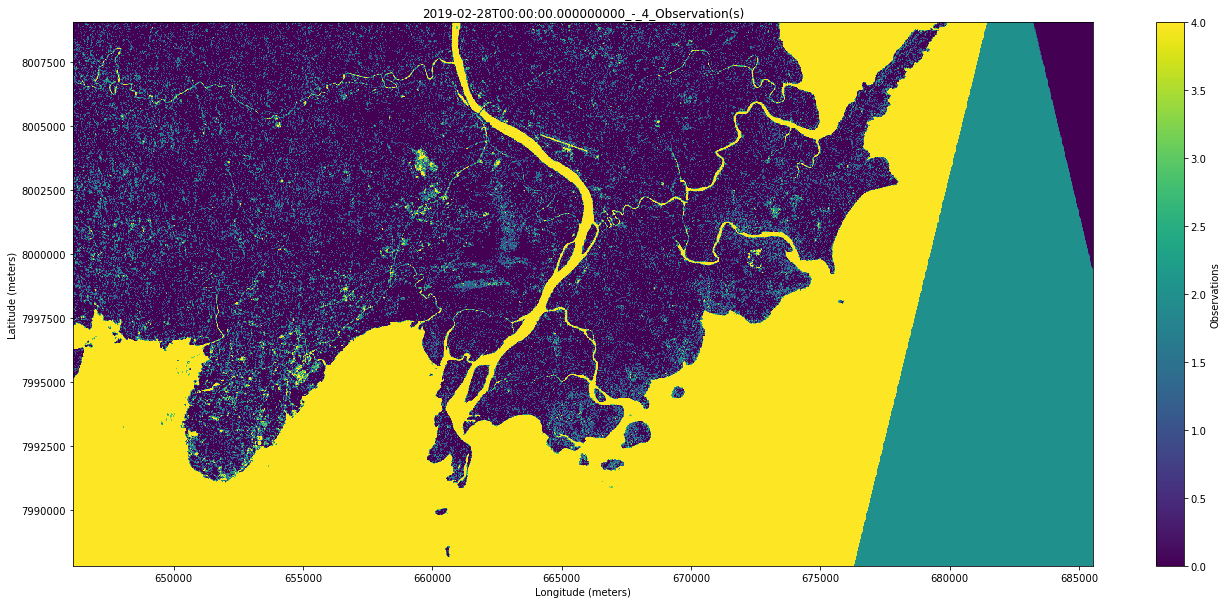

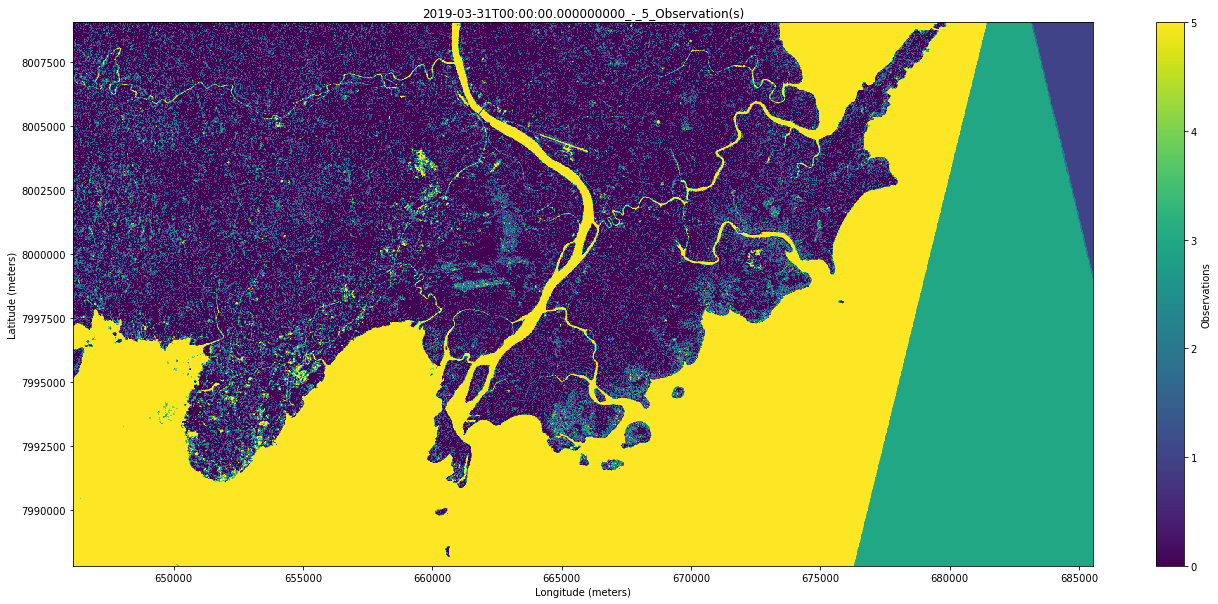

In [95]:
chunks = s1_coverage['Observations'].resample(time=time_step).sum('time')
for t in range(0, chunks.time.size):
    layer = chunks.isel(time=t)
    layer_max = layer.max().values
    layer_threshold = (layer_max / 100 ) * threshold
    print(f"{t} t: {layer_threshold} m: {layer_max}")
    print(layer.time.values)
    
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE   

# Threshold Images 
#    layer.where(layer > layer_threshold).plot.imshow(figsize=(12*ar,10))
# Full Range Images    
    layer.where(layer_max > layer_threshold).plot.imshow(figsize=(12*ar,10))
    
    plt.title(f"{layer.time.values}_-_{layer_max}_Observation(s)")
    plt.xlabel("Longitude (meters)")
    plt.ylabel("Latitude (meters)")
    contour = extract_contour(s1_coverage, layer, layer_threshold, min_vertices)
# Coastline Monitoring  
#    save_poly(f"Coastline_{t}.geojson", s1_coverage.crs, contour)
# Inland Water Monitoring        
    plt.savefig(f"Inland_{layer.time.values}.jpg")

In [96]:
for t in chunks.time:
    print(t.values)

2019-02-28T00:00:00.000000000
2019-03-31T00:00:00.000000000


### Coastline Compilation Tool
Unlike the inland water tool which simply uses jpg images, the coastline boundaries are stored as geojson files in alphabetical order, the following code converts these into index ordered jpg images and adds graph features such as titles. If you are using an inland AOI, this section will output blank maps and can be ignored. 

(As of V4 (Aug 2019) long time ranges still produce a lot of copies due to the for loops.)

In [43]:
# for t in range(chunks.time.size):
#     for i, t in enumerate(chunks.time):
#         t = t.values
#         print(i)
#         print(t)
#         gdf = gpd.read_file(f"Coastline_{i}.geojson")
#         for i in gdf.geometry[:1]: 
#             gdf.plot()
#             plt.title(f"{t}")
#             plt.xlabel("Longitude (meters)")
#             plt.ylabel("Latitude (meters)")
#             plt.xlim([xmin,xmax]) 
#             plt.ylim([ymin,ymax])
#             plt.tight_layout()
#             plt.savefig(f"Coastline_Map_{t}.jpg")
#             plt.show()

### Timelapse (GIF) Generator
This code collects the jpg images in order and produces the timelapse GIF. Select the correct option for the AOI in use for each of these two highlighted areas.

The code may require "pip install opencv-python" in Terminal if "ModuleNotFoundError: No module named 'cv2'" produced.

In [44]:
import cv2
import glob
from PIL import Image

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE
# Credit to original app author Wil Selwood for the following code in creating the GIF image 
# gif = glob.glob("Inland_water_monitoring/Coastline_Map_*.jpg")
# OR
gif = glob.glob("Inland_*.jpg")

gif.sort()
print(gif)

img = [None]*len(gif)
for t, p in enumerate(gif):
    img[t] = Image.open(p)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE
# Credit to Ella Buhner Gattis for the basis of the following code in creating the GIF image    
# img[0].save('Coastline_Map_Timelapse.gif', save_all=True, append_images=img[1:],loop=0,duration=1000)
# OR
img[0].save('Inland_Map_Timelapse.gif', save_all=True, append_images=img[1:],loop=0,duration=1000)

ModuleNotFoundError: No module named 'cv2'